<a href="https://colab.research.google.com/github/rony-boay/E-commerce_app/blob/main/Copy_of_haroon_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.84 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/78.2 GB disk)


In [ ]:
# import dependencies
import tensorflow as tf
import zipfile
import os
import albumentations as A
import cv2
import shutil
from ultralytics import YOLO
import yaml
from IPython.display import Image

In [ ]:
# Function to unzip the dataset from a zipfile
def zipping_dataset(zip_path: str, extract_dir: str):
    """
    Unzips the dataset from a specified zip file into a target directory.

    Args:
        zip_path (str): The path to the zip file to be extracted.
        extract_dir (str): The directory where the extracted files will be stored.

    Raises:
        Exception: Catches and prints any unexpected errors that occur during extraction.
    """
    try:
        with zipfile.ZipFile(zip_path, "r") as f:
            f.extractall(extract_dir)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Utilizing the function
zipping_dataset(zip_path="/content/ZipData/Multi-Class Detection.v1i.yolov8.zip", extract_dir="UnzipData")

In [ ]:
# since the dataset is small and it is causing the model to underfit we will try data augmentation to reduce the underfitting

# Define paths
base_dir = 'UnzipData'
source_dir = os.path.join(base_dir, 'train/images')  # Original images
augmented_dir = os.path.join(base_dir, 'augmented_images')  # Augmented images
train_dir = source_dir  # Moving augmented images back to train folder

# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=45, p=0.5)
])

In [ ]:
# Now make the data augmentation function that will do it all.
def data_augmentation(image_path, save_dir):
    """
    Applies data augmentation to the image at `image_path` and saves the result to `save_dir`.

    Parameters:
    - image_path (str): Path to the input image to augment.
    - save_dir (str): Directory where the augmented image will be saved.

    Returns:
    - None
    """

    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Check if the image was successfully loaded
    if image is None:
        raise FileNotFoundError(f"Image at {image_path} could not be loaded.")

    # Apply the augmentation pipeline
    augmented = transform(image=image)
    augmented_img = augmented['image']

    # Construct the path for saving the augmented image
    save_path = os.path.join(save_dir, os.path.basename(image_path))

    # Save the augmented image
    cv2.imwrite(save_path, augmented_img)

    print(f"Augmented image saved to {save_path}")

In [ ]:
# Create augmented_images directory if not exists
if not os.path.exists(augmented_dir):
    os.makedirs(augmented_dir)

# Perform augmentation
for image_name in os.listdir(source_dir):
    image_path = os.path.join(source_dir, image_name)
    data_augmentation(image_path, augmented_dir)

Augmented image saved to UnzipData/augmented_images/laptop7_jpeg.rf.9b1cee50a35bd631856810a36a6b927e.jpg
Augmented image saved to UnzipData/augmented_images/bag2_jpeg.rf.96b2a46afc552d6074c1cbf92d05d4bc.jpg
Augmented image saved to UnzipData/augmented_images/tv7_jpeg.rf.800c428086980d3e52a8f9950bcc2472.jpg
Augmented image saved to UnzipData/augmented_images/laptop3_jpeg.rf.782187366edca25fbabd462721b3188c.jpg
Augmented image saved to UnzipData/augmented_images/laptop6_jpg.rf.3e89c11473f34182bac75d05b66bf334.jpg
Augmented image saved to UnzipData/augmented_images/phone7_jpg.rf.b657fa1bf3fbade698dbfc5b869cfd5a.jpg
Augmented image saved to UnzipData/augmented_images/mouse4_jpeg.rf.734eafc230fadebc399112fe86c4ce54.jpg
Augmented image saved to UnzipData/augmented_images/key2_jpeg.rf.926e343037852b5a0a320f678728409e.jpg
Augmented image saved to UnzipData/augmented_images/bag4_jpeg.rf.e26e1e7dbc0a33fad0a4f192faa46c9b.jpg
Augmented image saved to UnzipData/augmented_images/key3_jpeg.rf.81d4a7e

In [ ]:
# Move augmented images to the train directory (so we can train on all data)
for filename in os.listdir(augmented_dir):
    src = os.path.join(augmented_dir, filename)
    dst = os.path.join(train_dir, filename)
    shutil.move(src, dst)

In [ ]:
# lets set the paths of training , testing and validation datasets dynamically

# Set base directory (project root)
base_dir = os.getcwd()

#laod the data.yaml file first
yaml_path = os.path.join(base_dir, 'UnzipData', 'data.yaml')

with open(yaml_path, 'r') as f:
  data_config = yaml.safe_load(f)

#update the paths with dynamic relative paths
data_config['train'] = os.path.join(base_dir, 'UnzipData', 'train', 'images')
data_config['val'] = os.path.join(base_dir, 'UnzipData', 'valid', 'images')
data_config['test'] = os.path.join(base_dir, 'UnzipData', 'test', 'images')

# save the updated file
with open(yaml_path, 'w') as f:
  yaml.safe_dump(data_config, f)

In [ ]:
# Load and train YOLOv8 model
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 180MB/s]


## Model Training

In [ ]:
data_yaml_path = os.path.join(base_dir, 'UnzipData', 'data.yaml')
# Fine-tune the model on your custom dataset
model.train(
    data=data_yaml_path,  # Path to your dataset YAML file
    epochs=100,           # Number of training epochs
    imgsz=640,            # Image size
    patience=20,          # Early stopping patience
    lr0=0.001,            # Learning rate for fine-tuning
    augment=True,         # Enable augmentation
    verbose=True,
    dropout=0.1
)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/UnzipData/data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sho

100%|██████████| 6.25M/6.25M [00:00<00:00, 129MB/s]


AMP: checks passed ✅


train: Scanning /content/UnzipData/train/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/UnzipData/valid/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.44G      1.569      9.625      2.041         24        640: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all          9         10      0.464     0.0667     0.0699     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.11G      1.574      9.234      2.051         24        640: 100%|██████████| 6/6 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all          9         10     0.0991      0.267      0.228     0.0907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.14G      1.271      3.116      1.748         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all          9         10      0.566      0.533      0.434      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       4.2G       1.15      2.418      1.612         18        640: 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all          9         10      0.235      0.669      0.296      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       4.2G      1.112      2.094      1.545         25        640: 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all          9         10       0.41      0.417      0.498       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       4.2G      1.093      2.111       1.57         19        640: 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


                   all          9         10      0.791        0.2      0.267       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       4.2G      1.145      1.953      1.639         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all          9         10      0.521        0.4      0.542      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       4.2G      1.083      1.705      1.509         24        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all          9         10      0.596      0.423      0.356       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       4.2G      1.159      1.604      1.593         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all          9         10      0.648      0.578      0.337      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.14G      1.124      1.503      1.535         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all          9         10      0.161      0.395      0.228      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.14G      1.091       1.42      1.554         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all          9         10      0.421      0.333      0.217      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.14G      1.064      1.376      1.544         16        640: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all          9         10      0.424      0.328      0.307      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.14G        1.2      1.487      1.604         21        640: 100%|██████████| 6/6 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all          9         10      0.844        0.4      0.353      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.16G      1.141      1.366      1.569         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all          9         10      0.242      0.356      0.314      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.14G      1.107      1.318      1.565         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all          9         10      0.642      0.367      0.405      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.19G      1.166      1.431      1.584         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all          9         10      0.314      0.267      0.175      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.14G      1.224      1.363      1.627         21        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all          9         10      0.314      0.267      0.157     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.19G      1.123      1.409      1.534         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all          9         10      0.191      0.447      0.354      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.16G      1.242      1.282      1.694         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all          9         10      0.463        0.4      0.466      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.19G      1.228      1.373      1.608         20        640: 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


                   all          9         10      0.497        0.4      0.422      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.16G      1.131      1.309      1.594         17        640: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all          9         10      0.411        0.4       0.41      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.19G      1.116      1.341      1.607         10        640: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all          9         10      0.197        0.3      0.329      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.16G      1.058      1.236      1.515         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all          9         10      0.387        0.3      0.266      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.18G      1.029      1.133      1.485         23        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          9         10      0.282        0.5      0.281      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.14G      1.088        1.2      1.538         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all          9         10      0.324      0.267      0.213      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.19G      1.094      1.255       1.58         17        640: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all          9         10      0.337      0.257      0.135     0.0461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.16G      1.189      1.183      1.559         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all          9         10      0.347      0.267      0.132     0.0476
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 7, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



27 epochs completed in 0.035 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 22.5MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


                   all          9         10      0.642        0.6      0.573       0.41
                   Bag          1          1      0.483          1      0.497       0.15
              Keyboard          3          3      0.396      0.667      0.775      0.615
                 Mouse          2          2          1          0      0.359      0.197
                 Phone          3          3      0.441      0.333      0.237      0.192
                    TV          1          1       0.89          1      0.995      0.895
Speed: 0.2ms preprocess, 14.6ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f10c6b3cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

## Model Validation

In [ ]:
model.val(data=data_yaml_path, imgsz=640)

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/UnzipData/valid/labels.cache... 9 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9/9 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


                   all          9         10      0.642        0.6      0.573      0.417
                   Bag          1          1      0.483          1      0.497       0.15
              Keyboard          3          3      0.396      0.667      0.775       0.65
                 Mouse          2          2          1          0      0.359      0.197
                 Phone          3          3       0.44      0.333      0.237      0.191
                    TV          1          1       0.89          1      0.995      0.895
Speed: 0.4ms preprocess, 71.3ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to runs/detect/train72


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f11f30aa70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

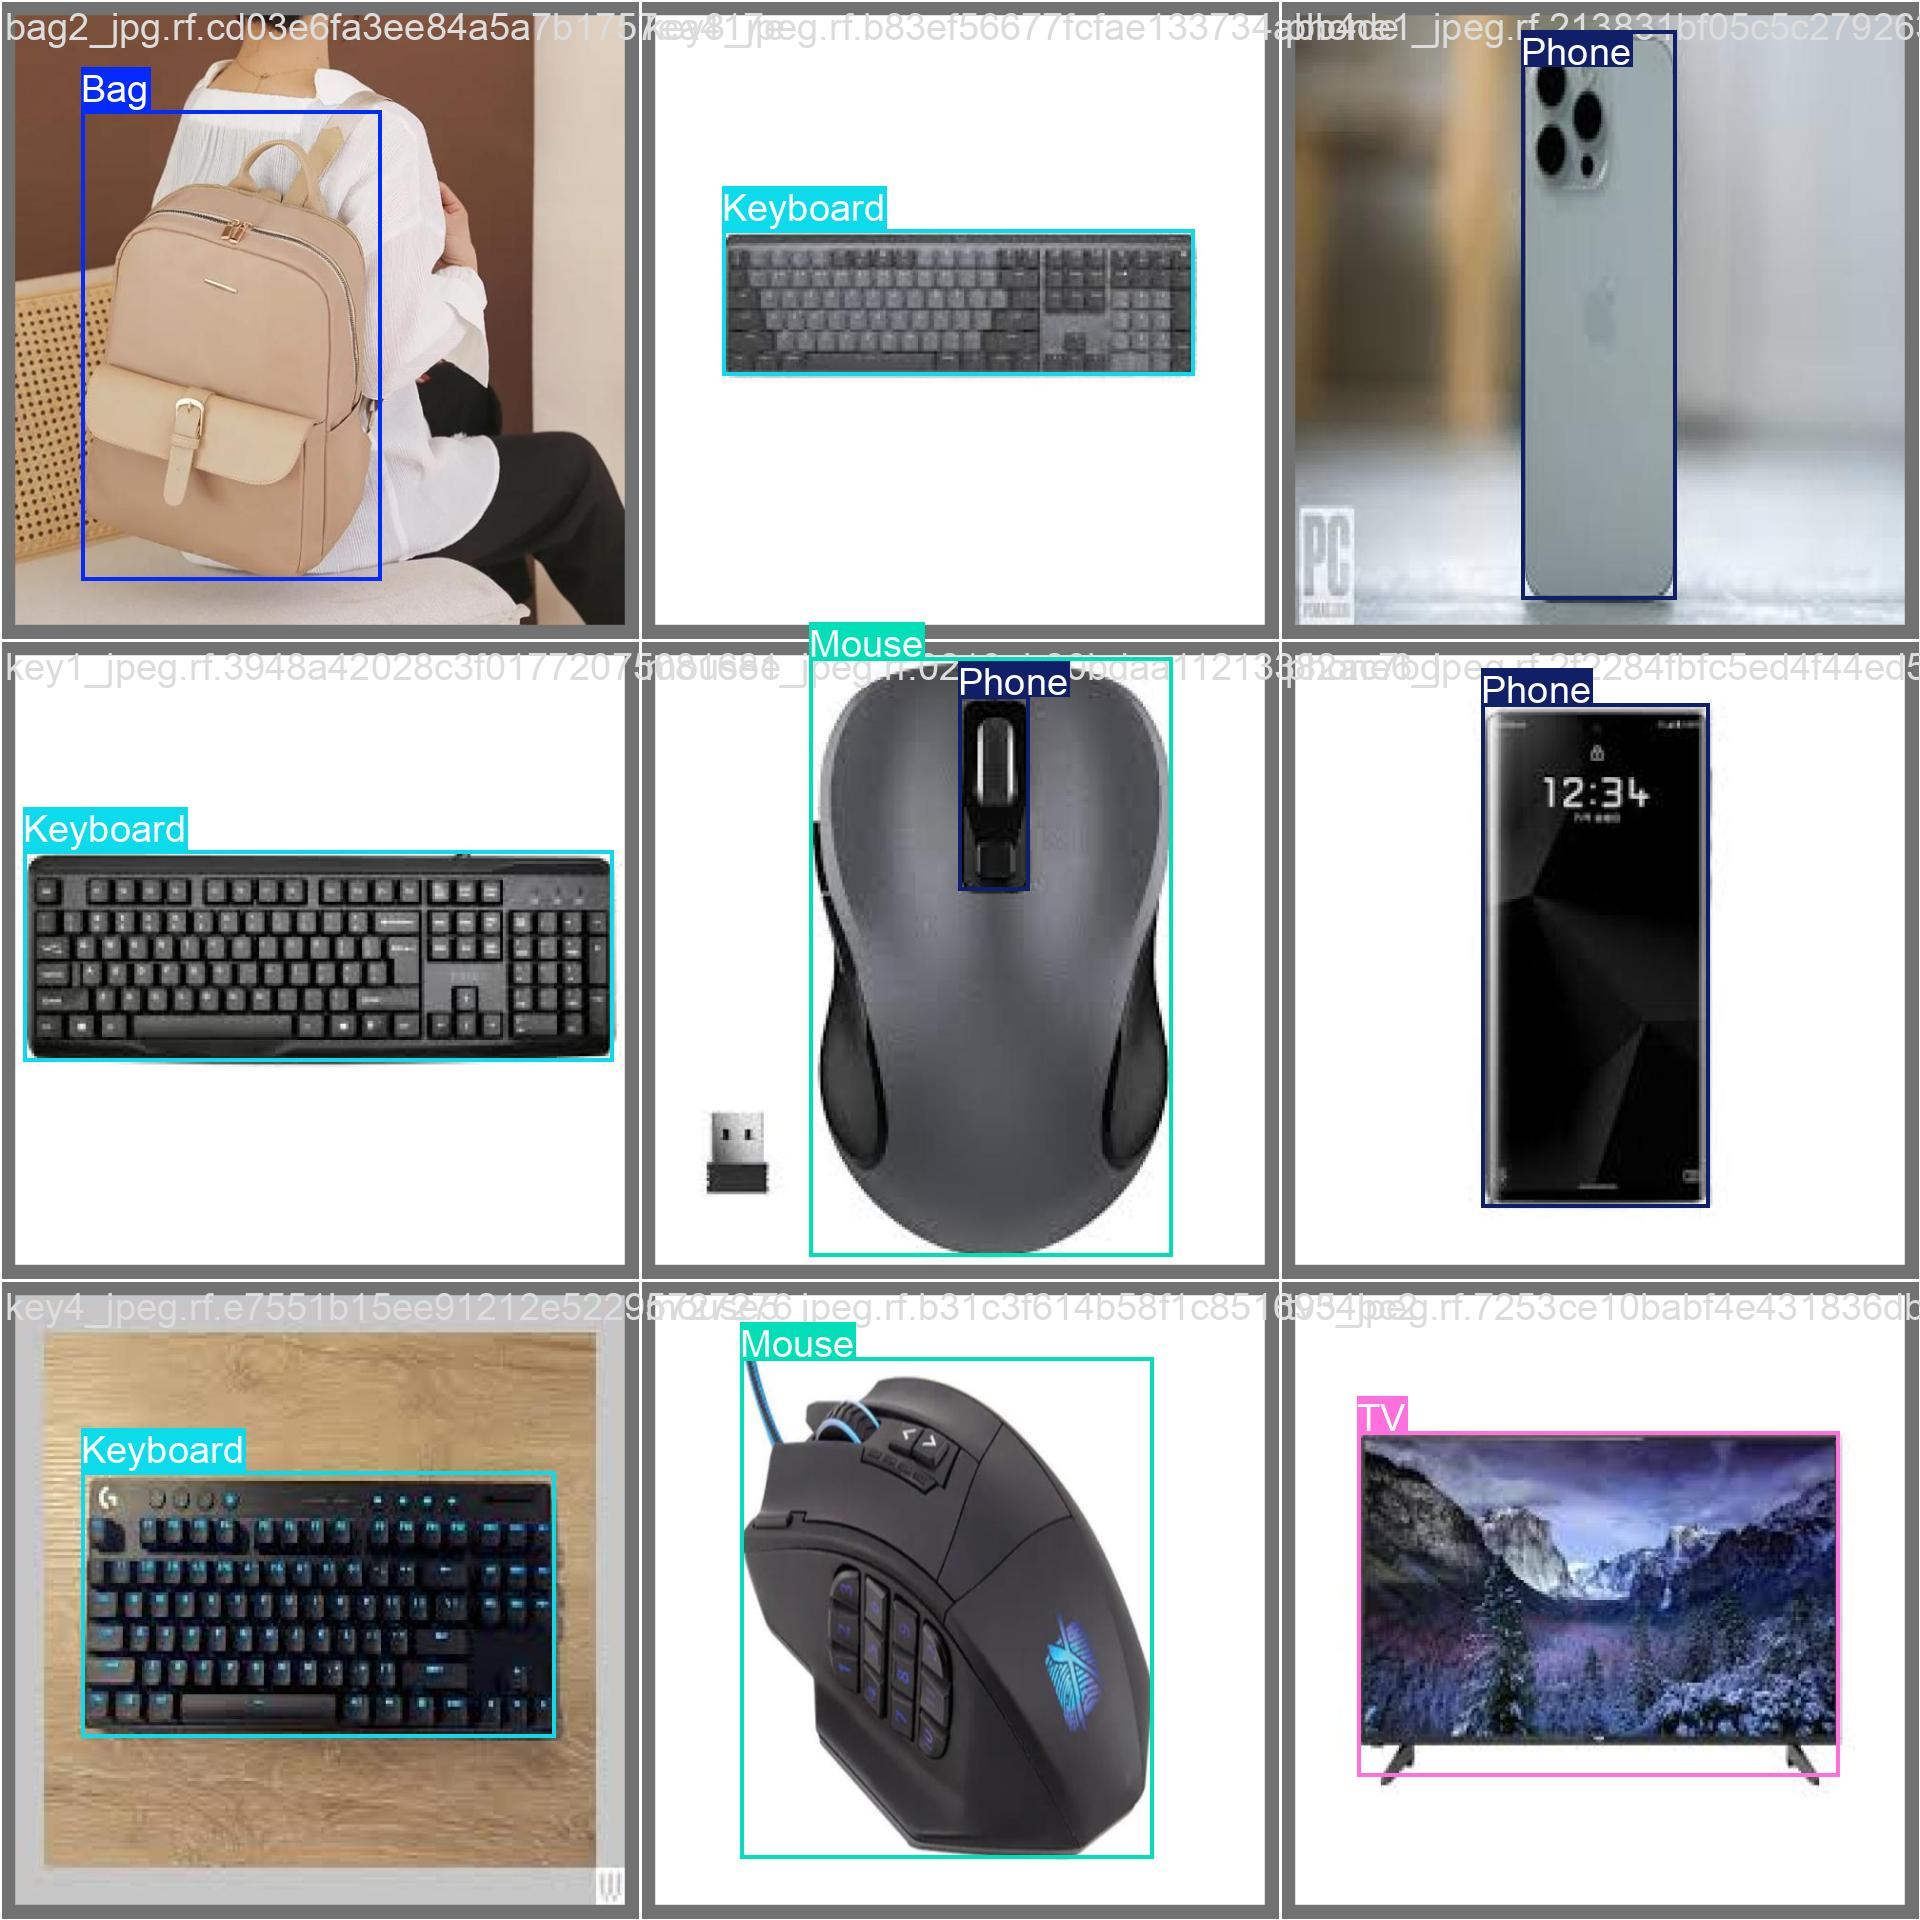

In [ ]:
Image(filename='/content/runs/detect/train2/val_batch0_labels.jpg', width=600)

In [ ]:
results = model.predict(source="//content/UnzipData/test/images", save=True, conf=0.5)

for result in results:
  print(result.boxes)


image 1/4 //content/UnzipData/test/images/bag1_jpg.rf.197ee501917a86bc32b53ab38e447f19.jpg: 640x640 1 Bag, 1 TV, 50.6ms
image 2/4 //content/UnzipData/test/images/key5_jpeg.rf.c4b27be99c4db72a4063567178f99854.jpg: 640x640 1 Keyboard, 1 Laptop, 1 TV, 57.4ms
image 3/4 //content/UnzipData/test/images/phone4_jpeg.rf.81824256a55e132fd0425704312af26e.jpg: 640x640 1 Keyboard, 1 TV, 49.7ms
image 4/4 //content/UnzipData/test/images/tv1_jpeg.rf.3d97b51472bb8ea9982d142d334eb06a.jpg: 640x640 1 TV, 37.2ms
Speed: 3.6ms preprocess, 48.7ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train73
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 5.], device='cuda:0')
conf: tensor([0.8026, 0.8019], device='cuda:0')
data: tensor([[ 68.6260,   0.7485, 586.7176, 576.5474,   0.8026,   0.0000],
        [ 66.7160,   0.0000, 586.1747, 583.3450,   0.8019,   5.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torc

## Now converting the model into Tensorflow Lite

In [ ]:
# Step 1: Automatically locate the best_saved_model directory
base_dir = os.getcwd()  # Get the current working directory
model_dir = None

# Traverse the directory tree to find 'best_saved_model'
for root, dirs, files in os.walk(base_dir):
    if 'best_saved_model' in dirs:
        model_dir = os.path.join(root, 'best_saved_model')
        break

# Check if the directory was found
if model_dir is None:
    raise FileNotFoundError("best_saved_model directory not found.")

# Step 2: Load the SavedModel
loaded_model = tf.saved_model.load(model_dir)

# Step 3: Manually create a signature for the model
@tf.function(input_signature=[tf.TensorSpec(shape=[None, 640, 640, 3], dtype=tf.float32)])
def detect_fn(input_tensor):
    return loaded_model(input_tensor)

# Step 4: Save the model with a proper signature
signatures = {'serving_default': detect_fn}
tf.saved_model.save(loaded_model, model_dir, signatures=signatures)

# Step 5: Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)

# Optional: Optimize the model for size and latency
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Step 6: Convert the model to TensorFlow Lite
tflite_model = converter.convert()

# Step 7: Save the converted TFLite model to a file in the base directory
tflite_model_path = os.path.join(base_dir, 'best_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved at:", tflite_model_path)


AttributeError: 'YOLO' object has no attribute 'best'